# 衛星画像の処理

Landsat  
アメリカ地質調査所(USGS)が運用する地球観測衛星。 アメリカが長年運用してきたランドサットシリーズに続く最新の衛星である。  



In [1]:
#今回使うデータ
from IPython.display import Image
Image(filename='LC81070352014087LGN00.jpg')

# 植生指数の計算

$NDVI = \frac{NIR - RED}{NIR + RED}$  

$NDVI$ (Normalized Difference Vegetation Index): 正規化植生指数  
$NIR$: 近赤外領域の反射率  
$RED$: 赤色領域の反射率  

Landsatのスペクトル反射率  
![Landsatのスペクトル反射率](http://www.opengis.co.jp/img/faq/spectrum/reflectance.gif)  

Landsat8の場合、赤色はバンド4（0.64-0.67μm）、近赤外はバンド5（0.85-0.88μm）

## 衛星画像処理で必要な情報

画像の  
* 縦と横のピクセル数
* 縦と横の空間分解能
* データ型（Integer？Float？）
* AOI（画像の撮像領域の緯度経度）
* 地図の投影法
  
などなど

In [2]:
from osgeo import gdal, osr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
ds04 = gdal.Open("LC81070352014087LGN00_B4.TIF")
Red = ds04.ReadAsArray().astype(np.float64)
ds05 = gdal.Open("LC81070352014087LGN00_B5.TIF")
Nir = ds05.ReadAsArray().astype(np.float64)

nil = -9999

In [4]:

denominator = np.where(Nir != 0, Nir + Red, nil)
numerator = np.where(Nir != 0, Nir - Red, nil)

NDVI = np.where((denominator != 0.) & (denominator != nil),
                   numerator / denominator,
                   nil)

del Red, Nir, denominator, numerator

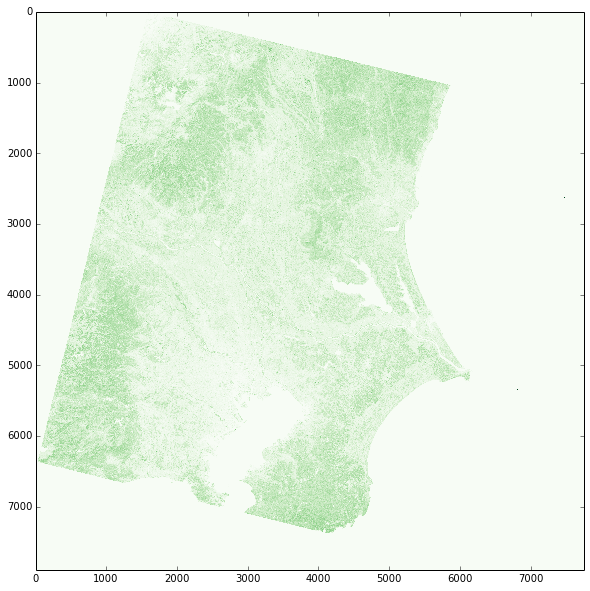

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(NDVI, interpolation='nearest', vmax=1., vmin=0., cmap=plt.cm.Greens)

In [6]:
cols = NDVI.shape[1]
rows = NDVI.shape[0]
driver = ds04.GetDriver()
outDS = driver.Create("NDVI.tif", cols, rows, 1, gdal.GDT_Float64)
outDS.SetGeoTransform(ds04.GetGeoTransform())
outDS.SetProjection(ds04.GetProjectionRef())
outBand = outDS.GetRasterBand(1)
outBand.SetNoDataValue(nil)
outBand.WriteArray(NDVI)
outDS = None
del outDS, outBand